In [1]:
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import akshare as ak
import warnings
warnings.filterwarnings('ignore')

# 股票代码集合
symbols = ["sh000001", "sh601998", "sh601398", "sh601939", "sh601288"]

# 获取数据
df = ak.stock_zh_a_daily(symbol=symbols[0], start_date="20201101", end_date="20231106")
df



/Users/bingbing/anaconda3/lib/python3.10/site-packages/akshare/__init__.py:2595: UserWarning: 为了支持更多特性，请将 Pandas 升级到 2.1.0 及以上版本！
  warnings.warn(


,date,open,high,low,close,volume,amount,outstanding_share,turnover
0,2020-11-02,3228.72,3242.80,3209.91,3225.12,2.267791e+10,3.253219e+11,1.940575e+10,1.168618
1,2020-11-03,3239.81,3278.38,3237.85,3271.07,2.152979e+10,3.037301e+11,1.940575e+10,1.109454
2,2020-11-04,3273.43,3286.62,3254.11,3277.44,1.885141e+10,2.707238e+11,1.940575e+10,0.971434
3,2020-11-05,3305.58,3320.41,3291.60,3320.13,2.268015e+10,3.162927e+11,1.940575e+10,1.168733
4,2020-11-06,3326.46,3326.46,3292.15,3312.16,2.348641e+10,3.254851e+11,1.940575e+10,1.210281
...,...,...,...,...,...,...,...,...,...
727,2023-10-31,3019.65,3023.00,3006.61,3018.77,3.198600e+10,3.862772e+11,1.940555e+10,1.648291
728,2023-11-01,3038.18,3038.33,3013.93,3023.08,2.801104e+10,3.471215e+11,1.940555e+10,1.443456
729,2023-11-02,3028.66,3038.64,3009.12,3009.41,2.687946e+10,3.119364e+11,1.940555e+10,1.385143
730,2023-11-03,3012.46,3040.98,3012.46,3030.80,2.684863e+10,3.293005e+11,1.940555e+10,1.383555


In [2]:
df1=df[['date','open','high','low','close','volume','amount','turnover']]

scaler1=MinMaxScaler()
None_data=scaler1.fit_transform(df1[['open','close']])
scaler=MinMaxScaler()
df1[['open','high','low','close','volume','amount','turnover']]=scaler.fit_transform(df1[['open','high','low','close','volume','amount','turnover']])





In [3]:
df1["date"] = pd.to_datetime(df1["date"], format="%Y-%m-%d")
# 判断每个日期属于星期几,其中 Monday 为 0，Tuesday 为 1，以此类推
df1['week_day'] = df1['date'].dt.dayofweek

# 判断月初 月中 月末
yczm = []
mr = []
for i in df.index:
    items = int(str(df1.loc[i,'date']).split(' ')[0].split("-")[-1])
    mr.append(items)
    if items < 10:
        #月初用0代表
        yczm.append(0)
    elif items < 20:
        #月中用1代表
        yczm.append(1)
    else:
        #月末用2代表
        yczm.append(2)
df1['day'] = mr
df1['month_period'] = yczm
df1=pd.get_dummies(df1)
df1

,date,open,high,low,close,volume,amount,turnover,week_day,day,month_period
0,2020-11-02,0.423637,0.393188,0.417598,0.408582,0.079925,0.159936,0.079925,0,2,0
1,2020-11-03,0.436618,0.437350,0.451295,0.464014,0.055944,0.124867,0.055944,1,3,0
2,2020-11-04,0.475974,0.447578,0.470905,0.471699,0.000000,0.071257,0.000000,2,4,0
3,2020-11-05,0.513608,0.489518,0.516119,0.523198,0.079972,0.145271,0.079972,3,5,0
4,2020-11-06,0.538050,0.497027,0.516782,0.513584,0.096812,0.160202,0.096812,4,6,0
...,...,...,...,...,...,...,...,...,...,...,...
727,2023-10-31,0.178901,0.120372,0.172413,0.159650,0.274345,0.258942,0.274352,1,31,2
728,2023-11-01,0.200592,0.139400,0.181241,0.164849,0.191319,0.195344,0.191325,2,1,0
729,2023-11-02,0.189448,0.139784,0.175441,0.148358,0.167683,0.138195,0.167689,3,2,0
730,2023-11-03,0.170485,0.142689,0.179469,0.174162,0.167040,0.166399,0.167046,4,3,0


In [4]:
#Params
time_window = 28
pred_window=7

BATCH_SIZE=16
nums_layer=1
lr=5e-4
test_size=0.2
N_epoch=100
device = torch.device('mps')

feature_count=10
Price_data=df1[['open', 'high', 'low', 'close', 'volume', 'amount', 'turnover',
       'week_day', 'day', 'month_period']].values


print(Price_data.shape)

data_his=[]
data_pred=[]
for i in range(len(Price_data)-time_window-pred_window):
    data_his.append(np.array(Price_data[i:i+time_window,]))
    data_pred.append(np.array(Price_data[i+time_window:i+time_window+pred_window,[0,3]]))

data_pred=np.array(data_pred)
data_his=np.array(data_his)

print(data_his.shape,data_pred.shape)
print(len(data_his),len(data_pred))

(732, 10)
(697, 28, 10) (697, 7, 2)
697 697


In [5]:
data_his=np.array(data_his)
data_pred=np.array(data_pred)

print(data_his.shape,data_pred.shape)

Train_x,Train_y=data_his[:-int(test_size*len(data_his))],data_pred[:-int(test_size*len(data_his))]
Test_x,Test_y=data_his[-int(test_size*len(data_his)):],data_pred[-int(test_size*len(data_his)):]
print(Train_x.shape,Train_y.shape,Test_x.shape,Test_y.shape)

class TimeDataset(Dataset):
    def __init__(self,df_x,df_y):
        self.data=df_x
        self.label=df_y
    def __len__(self):
        return len(self.data)
    def __getitem__(self,index):
        data_value=torch.FloatTensor(self.data[index,:])
        label_value=torch.FloatTensor([self.label[index,:]])
        return data_value,label_value.view(pred_window,2)

train_dataset=TimeDataset(df_x=Train_x,df_y=Train_y)
valid_dataset=TimeDataset(df_x=Test_x,df_y=Test_y)
train_iterator=DataLoader(train_dataset,batch_size=BATCH_SIZE)
valid_iterator=DataLoader(valid_dataset,batch_size=BATCH_SIZE)
#test
for (data,label) in train_iterator:
    print(data.shape)
    print(label.shape)
    break


(697, 28, 10) (697, 7, 2)
(558, 28, 10) (558, 7, 2) (139, 28, 10) (139, 7, 2)
torch.Size([16, 28, 10])
torch.Size([16, 7, 2])


In [6]:
class FCN(nn.Module):
    def __init__(self,InputDim=time_window*feature_count,OutputDim=pred_window*2,nums_layer=6):
        super().__init__()
        layers=[]
        for i in range(nums_layer):
            layers+=[nn.Linear(4096,4096),
                     nn.LeakyReLU(),
                     nn.Linear(4096,4096)
                     ]
        self.layer1=nn.Sequential(
            nn.Linear(InputDim, 4096),
            nn.LeakyReLU(),
        )
        self.layer2=nn.Sequential(*layers)
        self.layer3=nn.Sequential(
            nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(4096,64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32,out_features=OutputDim),

        )

    def forward(self,data):
        x=self.layer1(data)
        x=self.layer2(x)
        x=self.layer3(x)
        return x

def train(model, iterator, optimizer, criterion,device='cpu'):
    epoch_loss = 0
    model=model.to(device)
    model.train()
    for batch in iterator:
        batch[0]=batch[0].reshape(batch[0].shape[0],-1).to(device)
        batch[1]=batch[1].reshape(batch[1].shape[0],-1).to(device)
        criterion=criterion.to(device)
        optimizer.zero_grad()
        predictions = model(batch[0])

        #print(predictions.shape,batch[1].shape)

        loss = criterion(predictions, batch[1])
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def evaluate(model, iterator,criterion,device='cpu'):
    epoch_loss = 0
    model=model.to(device)
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            batch[0]=batch[0].reshape(batch[0].shape[0],-1).to(device)
            batch[1]=batch[1].reshape(batch[1].shape[0],-1).to(device)
            criterion=criterion.to(device)
            predictions = model(batch[0])
            loss = criterion(predictions, batch[1])
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

lossfunction=nn.MSELoss()
fc_model=FCN(nums_layer=nums_layer)
# fc_model=FullyConnectedModel()
optimizer=torch.optim.Adam(fc_model.parameters(),lr=lr)


In [7]:
train_loss_list=[]
valid_loss_list=[]

par=tqdm(range(N_epoch))

for i in par:
    train_loss=train(model=fc_model,iterator=train_iterator,criterion=lossfunction,optimizer=optimizer,device=device)
    valid_loss=evaluate(model=fc_model,iterator=valid_iterator,criterion=lossfunction,device=device)
    # print("Epoch:{}".format(i+1))
    # print("Training Loss:{:.4f}".format(train_loss),"Valid Loss:{:.4f}".format(valid_loss))
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    if i ==0:
        best_valid_loss=valid_loss
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        # print('Save Model..')
        par.set_description_str("Epoch:{}".format(i+1)+' Save!')
        torch.save(fc_model.state_dict(), './result/fc_model.pt')
    else:
        par.set_description_str("Epoch:{}".format(i+1))

    par.set_postfix_str("Training Loss:{:.4f}".format(train_loss)+" Valid Loss:{:.4f}".format(valid_loss))


Epoch:100: 100%|██████████| 100/100 [01:26<00:00,  1.15it/s, Training Loss:0.0138 Valid Loss:0.0090]    


In [8]:
fc_model.load_state_dict(torch.load('./result/fc_model.pt',map_location='cpu'))
fc_model.to('cpu')
train_iterator=DataLoader(train_dataset,batch_size=1)
valid_iterator=DataLoader(valid_dataset,batch_size=1)
list1_open=[]
list2_open=[]
real_y_1_open=[]
real_y_2_open=[]

with torch.no_grad():
    for batch in train_iterator:
        data=batch[0].reshape(batch[0].shape[0],-1).to('cpu')
        pre1=fc_model(data)[0][0]
        list1_open.append(pre1)
        real_y_1_open.append(batch[1].to('cpu')[0][0][0])

    for batch in valid_iterator:
         data=batch[0].reshape(batch[0].shape[0],-1).to('cpu')
         pre2=fc_model(data)[0][0]
         list2_open.append(pre2)
         real_y_2_open.append(batch[1].to('cpu')[0][0][0])

list2_open=np.array([i.detach().numpy() for i in list2_open]).reshape(-1)
list1_open=np.array([i.detach().numpy() for i in list1_open]).reshape(-1)
real_y_1_open=np.array([i.detach().numpy() for i in real_y_1_open]).reshape(-1)
real_y_2_open=np.array([i.detach().numpy() for i in real_y_2_open]).reshape(-1)

In [9]:
print(len(list1_open),len(list2_open),len(real_y_1_open),len(real_y_2_open))


558 139 558 139


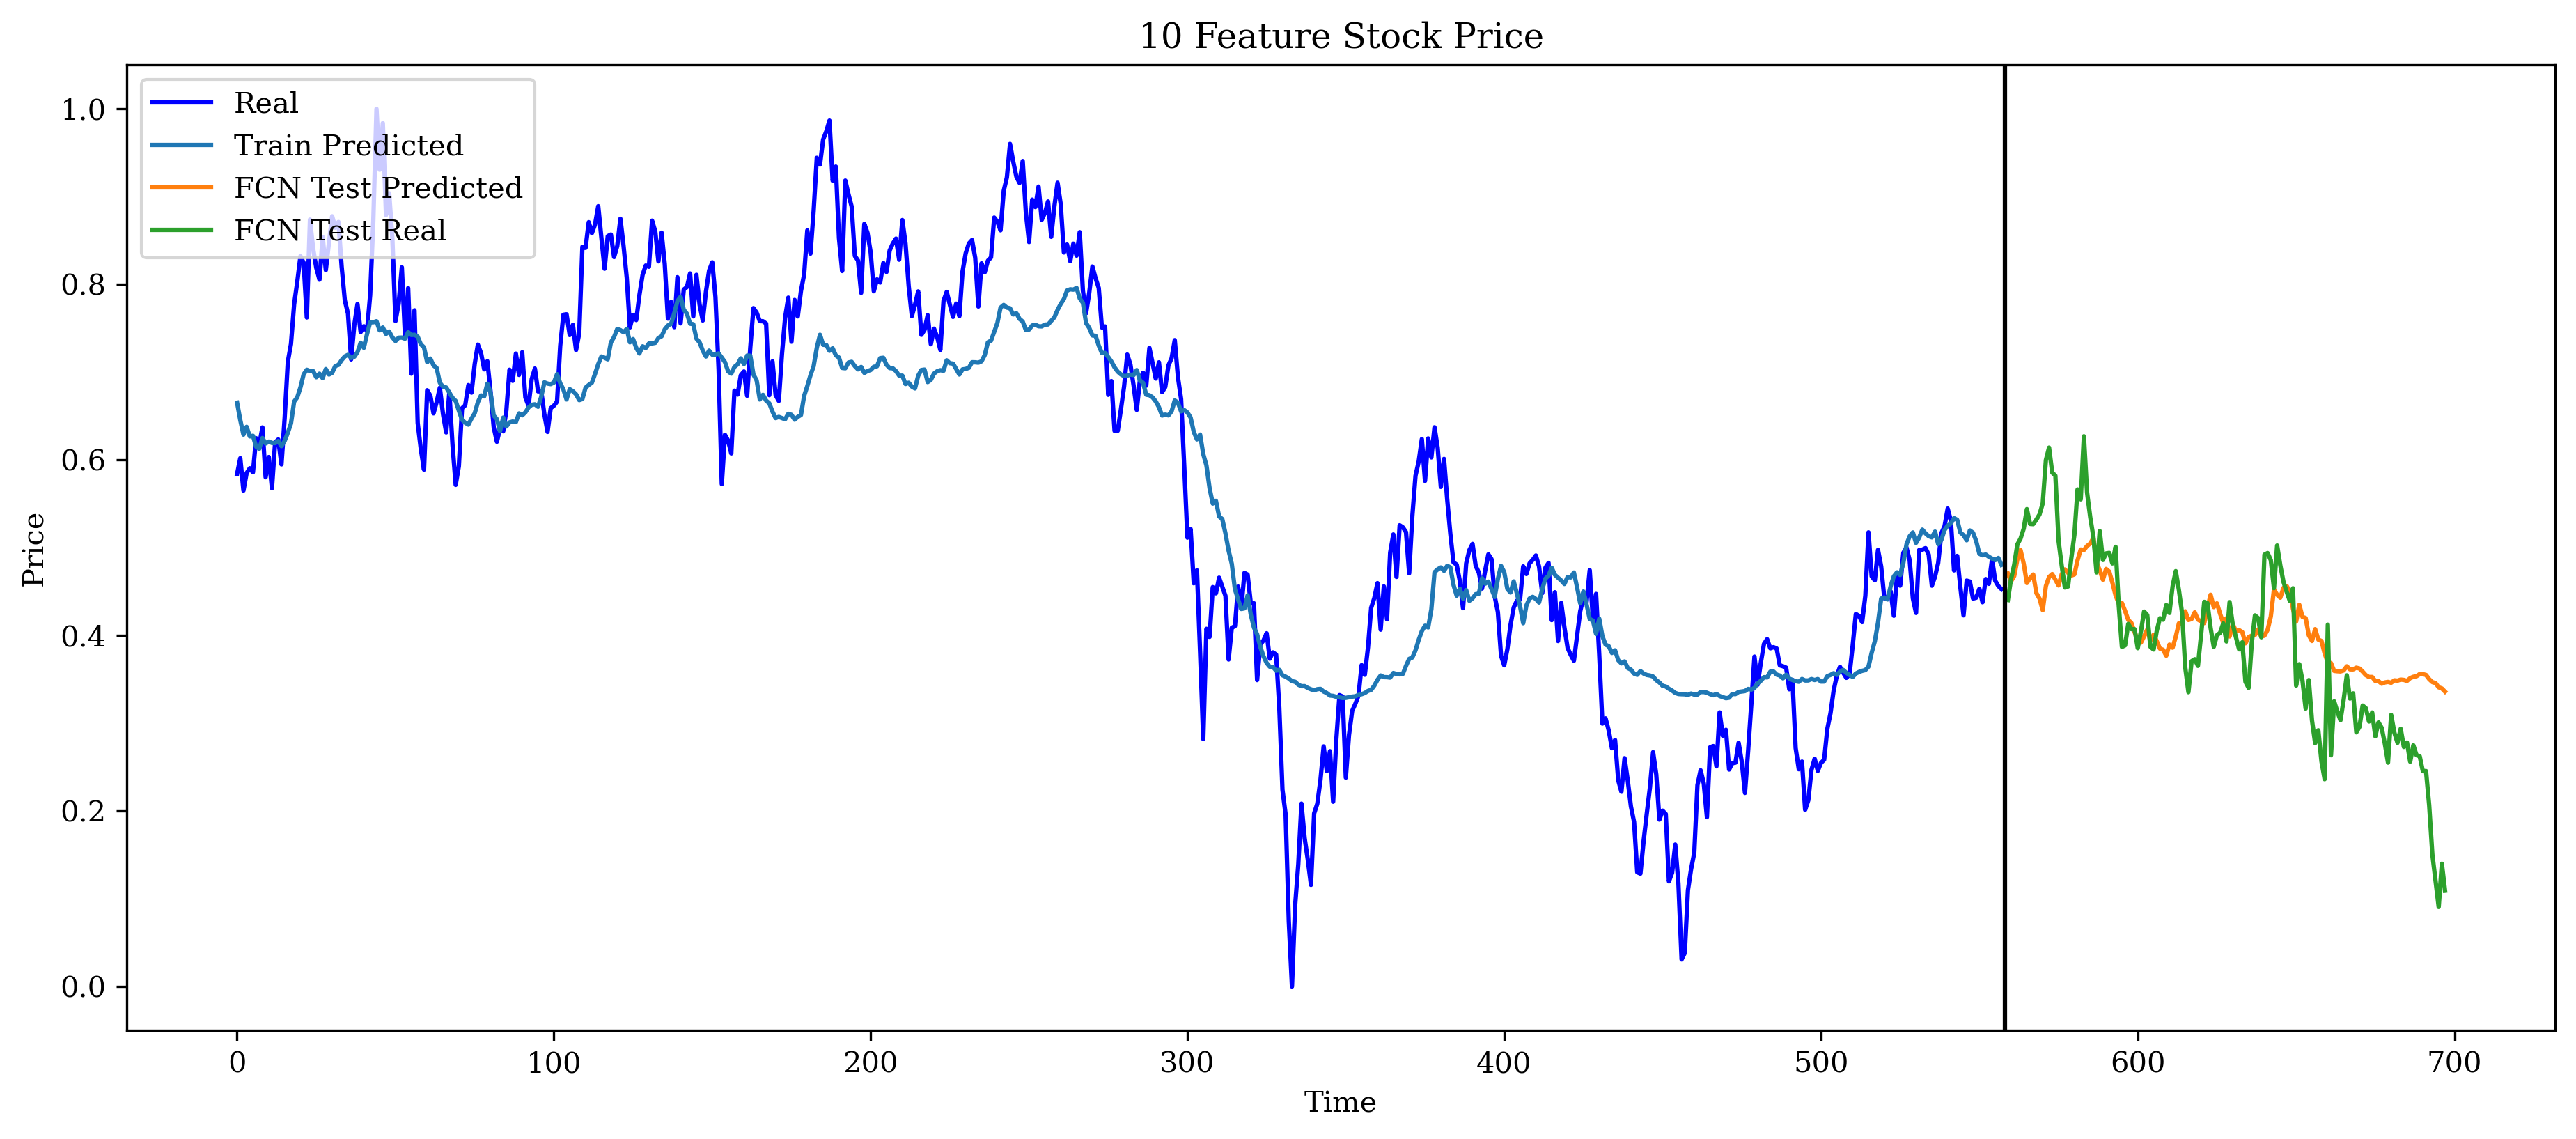

In [10]:
plt.rcParams['font.family']='serif'
plt.figure(figsize=(15,6),dpi=300)
plt.title('10 Feature Stock Price')
plt.plot(range(len(real_y_1_open)),real_y_1_open,color='blue',label='Real')
plt.plot(range(len(list1_open)),list1_open,label='Train Predicted')
plt.plot(range(len(real_y_1_open)+1,len(real_y_1_open)+len(list2_open)+1),list2_open,label='FCN Test Predicted')
plt.plot(range(len(real_y_1_open)+1,len(real_y_1_open)+len(list2_open)+1),real_y_2_open,label='FCN Test Real')
# plt.plot(range(len(Y_train_p)+1,len(Y_train_p)+len(Yvalidation)+1),Yvalidation)
# plt.plot(validation.index,pd.DataFrame(LSTM_pred),color='red',label='LSTM Predicted')
plt.xlabel('Time')
plt.ylabel('Price')
plt.axvline(len(real_y_1_open),color='black')
plt.legend(loc = "upper left")
plt.savefig('./result/4 Feature Prediction.jpg')

In [11]:
#prediction
pred_data=torch.FloatTensor(Price_data[-time_window:].reshape(1,-1))
pre1=fc_model(pred_data)[0].reshape(pred_window,2)
result=scaler1.inverse_transform(pre1.detach().numpy())

result

array([[3152.555 , 3104.9548],
       [3185.978 , 3131.8296],
       [3100.7854, 3087.7944],
       [3163.1836, 3112.1228],
       [3143.0916, 3181.4358],
       [3131.3948, 3134.6526],
       [3182.973 , 3105.1572]], dtype=float32)

In [12]:
from sklearn.metrics import r2_score,mean_squared_error

original, pred=real_y_1_open,list1_open
R2 = r2_score(original, pred)
mse = mean_squared_error(original,pred)
mape = np.mean(np.abs(original - pred)/original)
print("MSE is {},R2 is {}, MAPE is {}".format(mse,R2,mape))

MSE is 0.010424265637993813,R2 is 0.7939642219021867, MAPE is inf


In [13]:
fc_model.load_state_dict(torch.load('./result/fc_model.pt',map_location='cpu'))
fc_model.to('cpu')
train_iterator=DataLoader(train_dataset,batch_size=1)
valid_iterator=DataLoader(valid_dataset,batch_size=1)
list1_open=[]
list2_open=[]
real_y_1_open=[]
real_y_2_open=[]

with torch.no_grad():
    for batch in train_iterator:
        data=batch[0].reshape(batch[0].shape[0],-1).to('cpu')
        pre1=fc_model(data)[0][0]
        list1_open.append(pre1)
        real_y_1_open.append(batch[1].to('cpu')[0][0][0])

    for batch in valid_iterator:
         data=batch[0].reshape(batch[0].shape[0],-1).to('cpu')
         pre2=fc_model(data)[0][0]
         list2_open.append(pre2)
         real_y_2_open.append(batch[1].to('cpu')[0][0][0])

list2_open=np.array([i.detach().numpy() for i in list2_open]).reshape(-1)
list1_open=np.array([i.detach().numpy() for i in list1_open]).reshape(-1)
real_y_1_open=np.array([i.detach().numpy() for i in real_y_1_open]).reshape(-1)
real_y_2_open=np.array([i.detach().numpy() for i in real_y_2_open]).reshape(-1)

fc_model.load_state_dict(torch.load('./result/fc_model.pt',map_location='cpu'))
fc_model.to('cpu')
train_iterator=DataLoader(train_dataset,batch_size=1)
valid_iterator=DataLoader(valid_dataset,batch_size=1)
list1_close=[]
list2_close=[]
real_y_1_close=[]
real_y_2_close=[]

with torch.no_grad():
    for batch in train_iterator:
        data=batch[0].reshape(batch[0].shape[0],-1).to('cpu')
        pre1=fc_model(data)[0][1]
        list1_close.append(pre1)
        real_y_1_close.append(batch[1].to('cpu')[0][0][1])

    for batch in valid_iterator:
         data=batch[0].reshape(batch[0].shape[0],-1).to('cpu')
         pre2=fc_model(data)[0][1]
         list2_close.append(pre2)
         real_y_2_close.append(batch[1].to('cpu')[0][0][1])

list2_close=np.array([i.detach().numpy() for i in list2_close]).reshape(-1)
list1_close=np.array([i.detach().numpy() for i in list1_close]).reshape(-1)
real_y_1_close=np.array([i.detach().numpy() for i in real_y_1_close]).reshape(-1)
real_y_2_close=np.array([i.detach().numpy() for i in real_y_2_close]).reshape(-1)



In [14]:
df_open=pd.DataFrame({'Real_open':real_y_1_open,'Pred_open':list1_open})
df_close=pd.DataFrame({'Real_close':real_y_1_close,'Pred_close':list1_close})

result=scaler1.inverse_transform(df_open)
df1=pd.DataFrame(result,columns=['Real_open','Pred_open'])

original, pred=df1['Real_open'],df1['Pred_open']
R2 = r2_score(original, pred)
rmse = np.sqrt(mean_squared_error(original,pred))
mape = np.mean(np.abs(original - pred)/original)
print('Open:')
print("RMSE is {},R2 is {}, MAPE is {}".format(rmse,R2,mape))


result=scaler1.inverse_transform(df_close)
df1=pd.DataFrame(result,columns=['Real_close','Pred_close'])
original, pred=df1['Real_close'],df1['Pred_close']
R2 = r2_score(original, pred)
rmse = np.sqrt(mean_squared_error(original,pred))
mape = np.mean(np.abs(original - pred)/original)
print('Close:')
print("RMSE is {},R2 is {}, MAPE is {}".format(rmse,R2,mape))


Open:
RMSE is 88.48136138916016,R2 is 0.7879636030115355, MAPE is 0.020820291712880135
Close:
RMSE is 86.77897644042969,R2 is 0.8075223765133577, MAPE is 0.020469488576054573
